# Generative Models

# Autoencoders

Today we will use `keras` in `tensorflow` to build autoencoders. 

We will start with a simple neural network architecture that is composed of an input layer a lower-dimensional latent space, and an output layer of equal size.

<img src="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-06-at-3.17.13-PM.png" width="400" />

Autoencoders are an *unsupervised learning* method. We will begin by using an autoencoder to create a latent space representation of the `digits` dataset, a reduced-dimension version of the `MNIST` dataset. Replacing the `digits` dataset with the larger `MNIST` dataset is perhaps a more useful activity, but increases the runtime of the algorithm.

We will then extend this to create an autoencoder for the AT-TPC data.

In [14]:
import os
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import datasets, cluster # for k-means clustering
from sklearn.cluster import KMeans
import random # if we want to create a Variational Autoencoder
# This is simply an alias for convenience
layers = tf.keras.layers


In [2]:


def load_attpc_data():
    """Loads in the AT-TPC data.
        
    Returns:
        A tuple of the form ((real_features, real_targets), (simulated_features, simulated_targets))
    """
    simulated_data_origin = 'https://github.com/CompPhysics/MachineLearningMSU/raw/master/Day2_materials/data/simulated-attpc-events.h5'
    real_data_origin = 'https://github.com/CompPhysics/MachineLearningMSU/raw/master/Day2_materials/data/real-attpc-events.h5'
    
    simulated_path = tf.keras.utils.get_file('simulated-attpc-data.h5', origin=simulated_data_origin)
    real_path = tf.keras.utils.get_file('real-attpc-data.h5', origin=real_data_origin)
    
    with h5py.File(simulated_path, 'r') as h5:
        simulated_features = h5['features'][:]
        simulated_targets = h5['targets'][:]
        
    with h5py.File(real_path, 'r') as h5:
        real_features = h5['features'][:]
        real_targets = h5['targets'][:]
    
    return (real_features, real_targets), (simulated_features, simulated_targets)

def plot_learning_curve(history):
    """Plots a learning curve from a training history.
    
    Arguments:
        history (dict): The training history returned by `model.fit()`.
        
    Returns:
        None.
    """
    plt.figure(figsize=(11, 6), dpi=100)
    plt.plot(history.history['loss'], 'o-', label='Training Loss')
    plt.plot(history.history['val_loss'], 'o:', color='r', label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(0, len(history.history['loss'])), range(1, len(history.history['loss']) + 1))
    plt.show()
    
def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix.
    
    Adapted from:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    Arguments:
        y_true: Real class labels.
        y_pred: Predicted class labels.
        classes: List of class names.
        title: Title for the plot.
        cmap: Colormap to be used.
    
    Returns:
        None.
    """
    if not title:
        title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    plt.show()

## Data exploration

In [48]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

In [49]:
print('Training Features:\n   Shape: {}\n   Type: {}\n'.format(x_train.shape, x_train.dtype))


Training Features:
   Shape: (60000, 28, 28)
   Type: uint8



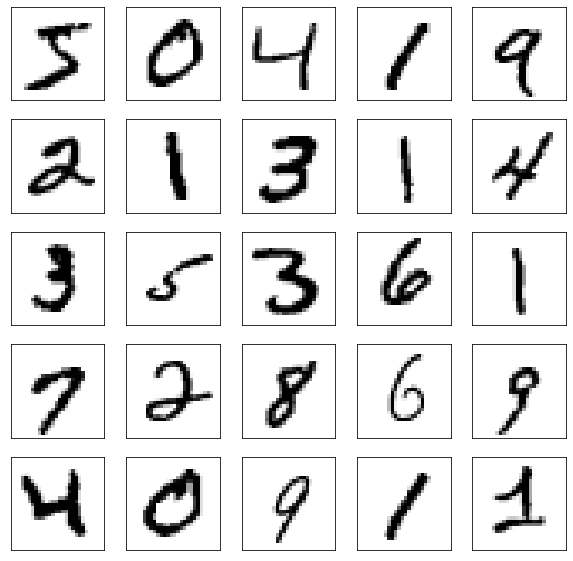

In [50]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    
plt.show()

### As always, we much rescale the data. Here, I rescaled the images to [0,1]

In [51]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Now we build the autoencoder. Ours is a standard feed-forward neural network architecture with three layers as descibed above.

Let's start by reducing our dimensionality by a factor of two and see if we can recover our original images.

One way to build an autoencoder is to store each layer into a variable so that we can access the different pieces later. 

*Note: I achieved my best performance with a `relu` activation function on both the encoded and output layers.*

In [87]:

latent_dim = 128

# define your Input layer
input_img = layers.Input(shape=(784,))
# define your encoded layer
encode = layers.Dense(256, activation='relu')(input_img)
latent = layers.Dense(latent_dim, activation='relu')(encode)
#encoded = layers.Dense(latent_dim, activation='relu')(input_img)






## Now, we build the encoder and decoder from the same layers.

Let's start with the encoder:

In [88]:
# this model maps an input to its encoded representation
encoder = tf.keras.models.Model(input_img, latent)

Now, for the decoder. This requires slightly more work because we want to have a latent representation as an Input in order to use the decoder as a generator.

In [92]:
# create a placeholder for an encoded (32-dimensional) input
latent_input = layers.Input(shape=(latent_dim,))
# retrieve the last layer of the autoencoder model
#decoder_layers = autoencoder.layers[-2:]
# create the decoder model
# define your output layer
decode = layers.Dense(256, activation='relu')(latent_input)
out = layers.Dense(784, activation='relu')(decode)
decoder = tf.keras.models.Model(latent_input, out)


# put the layers together to create your Model
autoencoder = tf.keras.models.Model(input_img, decoder(encoder(input_img)))

In [93]:
opt = tf.keras.optimizers.Adam(lr = 0.0001)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [94]:
autoencoder.fit(x_train, x_train,
                epochs=40,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 6s 106us/sample - loss: 0.3396 - val_loss: 0.2616
Epoch 2/40
60000/60000 [==============================] - 6s 95us/sample - loss: 0.2523 - val_loss: 0.2609
Epoch 3/40
60000/60000 [==============================] - 6s 92us/sample - loss: 0.2484 - val_loss: 0.2723
Epoch 4/40
60000/60000 [==============================] - 5s 90us/sample - loss: 0.2254 - val_loss: 0.2139
Epoch 5/40
60000/60000 [==============================] - 5s 92us/sample - loss: 0.2511 - val_loss: 0.2428
Epoch 6/40
60000/60000 [==============================] - 5s 91us/sample - loss: 0.2416 - val_loss: 0.2322
Epoch 7/40
60000/60000 [==============================] - 5s 90us/sample - loss: 0.2413 - val_loss: 0.2223
Epoch 8/40
60000/60000 [==============================] - 5s 91us/sample - loss: 0.2194 - val_loss: 0.2305
Epoch 9/40
60000/60000 [==============================] - 5s 90us/sample - loss: 0.2097 - val

In [61]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

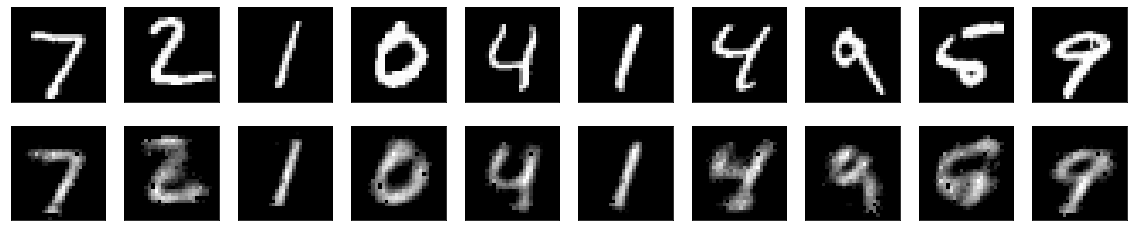

In [62]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


### We can try k-means clustering on the latent space to see if we can separate numbers

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [63]:
clust = KMeans(n_clusters=10).fit(x_test)

[4 2 5 ... 9 9 7]
[4 2 5 ... 9 9 7]


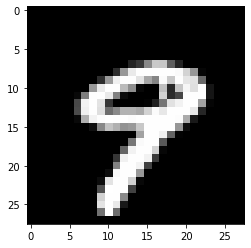

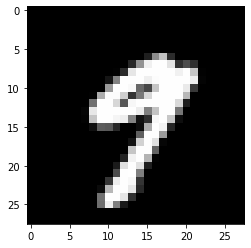

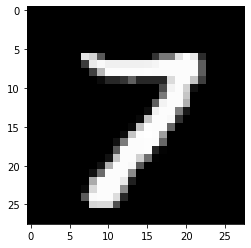

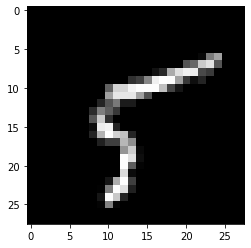

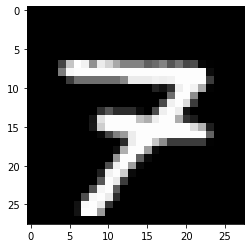

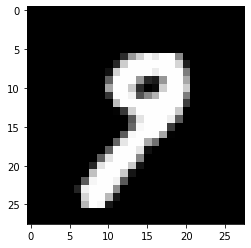

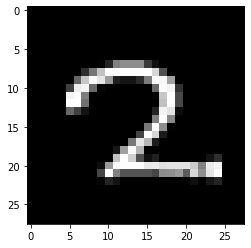

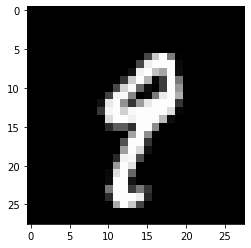

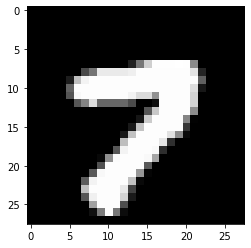

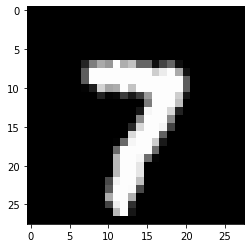

In [73]:
print(clust.labels_)
print(clust.predict(x_test))
#print(clust.cluster_centers_)
ind = np.where(clust.labels_ == 9)[0][:10]
for i in ind:
    plt.imshow(x_test[i].reshape((28,28)))
    plt.show()